In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import pad_sequences
from dataclasses import dataclass
from typing import List, Dict, Tuple
from tensorflow.keras.callbacks import EarlyStopping


SEED = 13
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -------------------------
# Data loading
# -------------------------

def read_conll(filepath: str) -> Tuple[List[List[str]], List[List[str]]]:
    sentences, tags = [], []
    cur_tokens, cur_tags = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if cur_tokens:
                    sentences.append(cur_tokens)
                    tags.append(cur_tags)
                    cur_tokens, cur_tags = [], []
                continue
            parts = line.split()
            token, tag = ' '.join(parts[:-1]) if len(parts) > 2 else parts[0], parts[-1]
            cur_tokens.append(token)
            cur_tags.append(tag)
    if cur_tokens:
        sentences.append(cur_tokens)
        tags.append(cur_tags)
    return sentences, tags


def build_vocab(sentences: List[List[str]], min_freq=1) -> Dict[str, int]:
    from collections import Counter
    counter = Counter(tok for sent in sentences for tok in sent)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for tok, c in counter.items():
        if c >= min_freq:
            vocab[tok] = len(vocab)
    return vocab


def build_label_map(tags: List[List[str]]) -> Dict[str, int]:
    uniq = sorted({t for seq in tags for t in seq})
    label2id = {"<PAD>": 0}
    for t in uniq:
        label2id[t] = len(label2id)
    return label2id


def to_ids(sentences, tags, token2id, label2id, max_len=None):
    X, y = [], []
    for toks, labs in zip(sentences, tags):
        X.append([token2id.get(tok, 1) for tok in toks])
        y.append([label2id[l] for l in labs])
    if max_len is None:
        max_len = max(len(s) for s in X)
    X = pad_sequences(X, maxlen=max_len, padding='post', value=0)
    y = pad_sequences(y, maxlen=max_len, padding='post', value=0)
    mask = (X != 0).astype('float32')
    return X, y, mask

@dataclass
class Dataset:
    X_train: np.ndarray
    y_train: np.ndarray
    m_train: np.ndarray
    X_val: np.ndarray
    y_val: np.ndarray
    m_val: np.ndarray
    token2id: Dict[str, int]
    id2label: Dict[int, str]


def make_dataset(path: str, val_split=0.1, min_freq=1) -> Dataset:
    sentences, tags = read_conll(path)
    idx = list(range(len(sentences)))
    random.shuffle(idx)
    sentences = [sentences[i] for i in idx]
    tags = [tags[i] for i in idx]

    n_val = max(1, int(len(sentences) * val_split)) if len(sentences) > 1 else 0
    train_s, val_s = sentences[:-n_val], sentences[-n_val:]
    train_t, val_t = tags[:-n_val], tags[-n_val:]

    token2id = build_vocab(sentences, min_freq)
    label2id = build_label_map(tags)
    id2label = {i: l for l, i in label2id.items()}

    X_train, y_train, m_train = to_ids(train_s, train_t, token2id, label2id)
    X_val, y_val, m_val = to_ids(val_s, val_t, token2id, label2id, X_train.shape[1])

    return Dataset(X_train, y_train, m_train, X_val, y_val, m_val, token2id, id2label)

# -------------------------
#  RNN Model
# -------------------------

def build_model(vocab_size, num_labels, emb_dim=128, rnn_units=128):
    inp = layers.Input(shape=(None,), dtype='int32')
    x = layers.Embedding(vocab_size, emb_dim, mask_zero=True)(inp)
    x = layers.SimpleRNN(rnn_units, return_sequences=True, dropout=0.2)(x)
    x = layers.SimpleRNN(rnn_units, return_sequences=True, dropout=0.2)(x)
    out = layers.TimeDistributed(layers.Dense(num_labels, activation='softmax'))(x)

    model = Model(inp, out)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='token_acc')])
    return model

def masked_accuracy(y_true, y_pred, mask):
    y_pred_labels = y_pred.argmax(-1)
    correct = (y_pred_labels == y_true) * mask
    return float(correct.sum() / (mask.sum() + 1e-9))


In [ ]:
# Instead of using argparse, just set parameters directly
data_path = 'FindVehicle_train.txt'
epochs = 50
batch_size = 32

# Build dataset and model
ds = make_dataset(data_path)
model = build_model(len(ds.token2id), len(ds.id2label))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 128) │    474,624 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_4        │ (None, None, 128) │     32,896 │ embedding_2[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_5        │ (None, None, 128) │     32,896 │ simple_rnn_4[0][… │
│ (SimpleRNN)         │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, None, 59)  │      7,611 │ simple_rnn_5[0][… │
│ (TimeDistributed)   │                   │            │ not_equal_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 548,027 (2.09 MB)

 Trainable params: 548,027 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

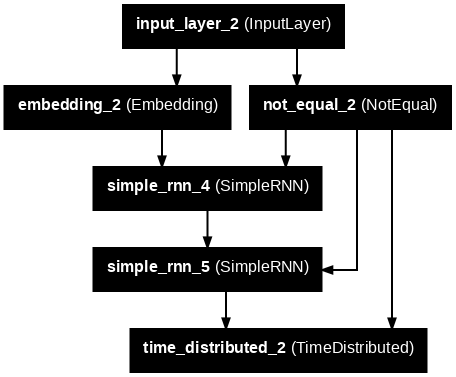

In [ ]:
from tensorflow.keras.utils import plot_model
import keras

#model = keras.Model(ds.X_train,ds.y_train, name="SimpleRNN_Sequence_Labeler")
plot_model(model, show_layer_names=True, to_file="rnn_model.png", dpi=72)


In [ ]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Instead of using argparse, just set parameters directly
data_path = 'FindVehicle_train.txt'
epochs = 50
batch_size = 32

# Build dataset and model
ds = make_dataset(data_path)
model = build_model(len(ds.token2id), len(ds.id2label))
model.summary()

# Train
model.fit(
    ds.X_train,
    ds.y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(ds.X_val, ds.y_val),
    callbacks=[early_stop],
    verbose=2
)

# Predict and evaluate
preds = model.predict(ds.X_val, verbose=0)
print('Validation masked accuracy:', masked_accuracy(ds.y_val, preds, ds.m_val))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 128) │    474,624 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_6        │ (None, None, 128) │     32,896 │ embedding_3[0][0… │
│ (SimpleRNN)         │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_7        │ (None, None, 128) │     32,896 │ simple_rnn_6[0][… │
│ (SimpleRNN)         │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, None, 59)  │      7,611 │ simple_rnn_7[0][… │
│ (TimeDistributed)   │                   │            │ not_equal_3[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 548,027 (2.09 MB)

 Trainable params: 548,027 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
607/607 - 43s - 71ms/step - loss: 0.6721 - token_acc: 0.3861 - val_loss: 0.4394 - val_token_acc: 0.4010
Epoch 2/50
607/607 - 7s - 12ms/step - loss: 0.4137 - token_acc: 0.3985 - val_loss: 0.3896 - val_token_acc: 0.4002
Epoch 3/50
607/607 - 10s - 17ms/step - loss: 0.3746 - token_acc: 0.3999 - val_loss: 0.3707 - val_token_acc: 0.3995
Epoch 4/50
607/607 - 7s - 11ms/step - loss: 0.3559 - token_acc: 0.4005 - val_loss: 0.3596 - val_token_acc: 0.3988
Epoch 5/50
607/607 - 7s - 11ms/step - loss: 0.3458 - token_acc: 0.4012 - val_loss: 0.3551 - val_token_acc: 0.3976
Epoch 6/50
607/607 - 7s - 11ms/step - loss: 0.3394 - token_acc: 0.4017 - val_loss: 0.3505 - val_token_acc: 0.3975
Epoch 7/50
607/607 - 7s - 11ms/step - loss: 0.3335 - token_acc: 0.4025 - val_loss: 0.3506 - val_token_acc: 0.3965
Epoch 8/50
607/607 - 7s - 11ms/step - loss: 0.3299 - token_acc: 0.4028 - val_loss: 0.3485 - val_token_acc: 0.3959
Epoch 9/50
607/607 - 7s - 11ms/step - loss: 0.3269 - token_acc: 0.4034 - val_loss: 0.3

In [ ]:
import numpy as np

def infer_sentence(sentence: str, model, ds, max_len=None):
    """
    Run NER inference on a given sentence string.
    """
    token2id = ds.token2id
    id2label = ds.id2label

    # Tokenize
    tokens = sentence.strip().split()
    seq = [token2id.get(tok, token2id["<UNK>"]) for tok in tokens]

    # Determine max_len
    if max_len is None:
        max_len = ds.X_train.shape[1]  # fallback to training max length

    # Pad sequence
    X = np.zeros((1, max_len), dtype="int32")
    X[0, :len(seq)] = seq[:max_len]

    # Predict
    pred = model.predict(X, verbose=0)[0]
    pred_ids = pred.argmax(axis=-1)

    # Decode
    decoded = []
    for i, tok in enumerate(tokens):
        if i >= max_len:
            break
        tag = id2label.get(pred_ids[i], "<PAD>")
        decoded.append((tok, tag))

    print("\n Inference Result:")
    for tok, tag in decoded:
        print(f"{tok:15s} -> {tag}")
    return decoded

# Example
example_sentence = "find the Silver van in the Top-Left"
infer_sentence(example_sentence, model, ds)



 Inference Result:
find            -> O
the             -> O
Silver          -> B-vehicle_color
van             -> B-vehicle_type
in              -> O
the             -> O
Top-Left        -> B-vehicle_location


[('find', 'O'),
 ('the', 'O'),
 ('Silver', 'B-vehicle_color'),
 ('van', 'B-vehicle_type'),
 ('in', 'O'),
 ('the', 'O'),
 ('Top-Left', 'B-vehicle_location')]

In [ ]:
!pip install seqeval

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

# Load trained model
#model = load_model("ner_rnn_keras")

# Load the new test data (reuse same vocab and label maps!)
test_sentences, test_tags = read_conll("FindVehicle_test.txt")

# Convert using the training token/label vocabularies
X_test, y_test, m_test = to_ids(test_sentences, test_tags, ds.token2id, {v: k for k, v in ds.id2label.items()}, ds.X_train.shape[1])

# Predict
preds = model.predict(X_test, verbose=0)
y_pred_ids = preds.argmax(-1)

# Convert to label names (ignoring PAD = 0)
true_tags = []
pred_tags = []
for true_seq, pred_seq in zip(y_test, y_pred_ids):
    true_seq_labels = []
    pred_seq_labels = []
    for t, p in zip(true_seq, pred_seq):
        if t == 0:  # skip PAD
            continue
        true_seq_labels.append(ds.id2label[t])
        pred_seq_labels.append(ds.id2label[p])
    true_tags.append(true_seq_labels)
    pred_tags.append(pred_seq_labels)

# Evaluate
print("Entity-level Evaluation (Standard NER on test file)\n")
print(classification_report(true_tags, pred_tags, digits=4))
print("Precision:", precision_score(true_tags, pred_tags))
print("Recall:", recall_score(true_tags, pred_tags))
print("F1 Score:", f1_score(true_tags, pred_tags))

# Token-level accuracy
from sklearn.metrics import accuracy_score
mask = y_test.flatten() != 0
y_true_flat = y_test.flatten()[mask]
y_pred_flat = y_pred_ids.flatten()[mask]
print("Token-level accuracy:", accuracy_score(y_true_flat, y_pred_flat))


Entity-level Evaluation (Standard NER on test file)

                          precision    recall  f1-score   support

           vehicle_brand     0.4942    0.9496    0.6501     17270
           vehicle_color     0.4994    0.9307    0.6500     18660
        vehicle_location     0.9050    0.8010    0.8498     10962
           vehicle_model     0.2542    0.4159    0.3155     17270
     vehicle_orientation     0.7244    0.7084    0.7163      5823
           vehicle_range     0.9946    1.0000    0.9973       183
            vehicle_type     0.9972    0.9843    0.9907      1464
        vehicle_type-bus     0.0406    0.0743    0.0525       471
      vehicle_type-coupe     0.0073    0.0118    0.0090       932
 vehicle_type-estate_car     0.0000    0.0000    0.0000       483
  vehicle_type-hatchback     0.0000    0.0000    0.0000      1562
 vehicle_type-motorcycle     0.0004    0.0004    0.0004      2482
        vehicle_type-mpv     0.0000    0.0000    0.0000       539
   vehicle_type-roadst

In [ ]:
import pandas as pd
from io import StringIO

report_text = """
           vehicle_brand     0.4958    0.9388    0.6489     17270
           vehicle_color     0.5124    0.9876    0.6747     18660
        vehicle_location     0.8540    0.8381    0.8459     10962
           vehicle_model     0.2625    0.4626    0.3350     17270
     vehicle_orientation     0.6612    0.8468    0.7426      5823
           vehicle_range     1.0000    1.0000    1.0000       183
            vehicle_type     0.9959    0.9891    0.9925      1464
        vehicle_type-bus     0.0000    0.0000    0.0000       471
      vehicle_type-coupe     0.0000    0.0000    0.0000       932
 vehicle_type-estate_car     0.0000    0.0000    0.0000       483
  vehicle_type-hatchback     0.0000    0.0000    0.0000      1562
 vehicle_type-motorcycle     0.0000    0.0000    0.0000      2482
        vehicle_type-mpv     0.0000    0.0000    0.0000       539
   vehicle_type-roadster     0.0000    0.0000    0.0000       339
      vehicle_type-sedan     0.0000    0.0000    0.0000      3680
 vehicle_type-sports_car     0.0779    0.1651    0.1058      1587
        vehicle_type-suv     0.0000    0.0000    0.0000      2570
      vehicle_type-truck     0.0000    0.0000    0.0000       867
        vehicle_type-van     0.0000    0.0000    0.0000       562
vehicle_type-vintage_car     0.0000    0.0000    0.0000      1397
        vehicle_velocity     0.7842    0.8939    0.8355      7814
"""

# --- Parse the report into a DataFrame ---
df = pd.read_csv(
    StringIO(report_text),
    delim_whitespace=True,
    names=["Entity", "Precision", "Recall", "F1", "Support"]
)

# --- Filter only the 8 base entities (no dash '-') ---
basic_entities = [
    "vehicle_brand", "vehicle_color", "vehicle_location", "vehicle_model",
    "vehicle_orientation", "vehicle_range", "vehicle_type", "vehicle_velocity"
]

df_basic = df[df["Entity"].isin(basic_entities)]

# --- Compute averages ---
avg_precision = df_basic["Precision"].mean()
avg_recall = df_basic["Recall"].mean()
avg_f1 = df_basic["F1"].mean()

print("Average (8 Basic Entities Only)")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1 Score:  {avg_f1:.4f}")

df_basic["Correct"] = df_basic["Recall"] * df_basic["Support"]
accuracy = df_basic["Correct"].sum() / df_basic["Support"].sum()

print(f"Accuracy: {accuracy:.4f}")


Average (8 Basic Entities Only)
Precision: 0.6957
Recall:    0.8696
F1 Score:  0.7594
Accuracy: 0.8228


/tmp/ipython-input-1280706775.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-1280706775.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic["Correct"] = df_basic["Recall"] * df_basic["Support"]
